In [133]:
import spatialdata
import spatialdata_plot
import napari
import napari_spatialdata

import sopa.segmentation
import sopa.io
from sopa._sdata import get_spatial_image

import matplotlib.pyplot as plt
import math
import numpy as np
import xarray
import xarray as xr

import skimage.exposure
from spatialdata.transformations import Identity

In [7]:
path_to_image = "../data/991_subset.ome.tif"
sdata = sopa.io.ome_tif(path_to_image, as_image=False)

INFO     `dims` is specified redundantly: found also inside `data`.                                                


In [5]:
sdata

SpatialData object
└── Images
      └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images)

In [8]:
patches = sopa.segmentation.Patches2D(sdata, element_name="991_subset", patch_width=1200, patch_overlap=100)
patches.write()

[INFO] (sopa.patches.patches) 64 patches were saved in sdata['sopa_patches']


,geometry,bboxes,ilocs
0,"POLYGON ((1200 0, 1200 1200, 0 1200, 0 0, 1200...","[0, 0, 1200, 1200]","[0, 0]"
1,"POLYGON ((2300 0, 2300 1200, 1100 1200, 1100 0...","[1100, 0, 2300, 1200]","[1, 0]"
2,"POLYGON ((3400 0, 3400 1200, 2200 1200, 2200 0...","[2200, 0, 3400, 1200]","[2, 0]"
3,"POLYGON ((4500 0, 4500 1200, 3300 1200, 3300 0...","[3300, 0, 4500, 1200]","[3, 0]"
4,"POLYGON ((5600 0, 5600 1200, 4400 1200, 4400 0...","[4400, 0, 5600, 1200]","[4, 0]"
...,...,...,...
59,"POLYGON ((4500 7700, 4500 8900, 3300 8900, 330...","[3300, 7700, 4500, 8900]","[3, 7]"
60,"POLYGON ((5600 7700, 5600 8900, 4400 8900, 440...","[4400, 7700, 5600, 8900]","[4, 7]"
61,"POLYGON ((6700 7700, 6700 8900, 5500 8900, 550...","[5500, 7700, 6700, 8900]","[5, 7]"
62,"POLYGON ((7800 7700, 7800 8900, 6600 8900, 660...","[6600, 7700, 7800, 8900]","[6, 7]"


In [ ]:
def calculate_quantile(sdata, key: str, channels: list, quantile_value: float = 0.9, return_ArrayData: bool = False):

    image = sdata.images[key]['scale0'].image
    assert type(image) == xarray.core.dataarray.DataArray, 'Image is not a xarray DataArray'
    selected_channels_image = image.sel(c=channels)

    # Max-scale each channel
    def max_scale(channel):
        return rescale_intensity(channel, in_range='image', out_range=(0, 1))

    max_scaled_channels = xr.concat([max_scale(selected_channels_image.sel(c=c)) for c in channels], dim='c')

    quantile_projection = max_scaled_channels.chunk({'c': -1}).quantile(quantile_value, dim='c', keep_attrs=True, interpolation='linear')
    
    # sdata does not like x, y only, so we create a dummy channel dimension
    quantile_projection_expanded = quantile_projection.expand_dims(dim='c', axis=0)

    if return_ArrayData:
        return quantile_projection_expanded
    else:
        sdata.images[f'{key}_q{int(quantile_value*100)}_projection'] = spatialdata.models.Image2DModel.parse(data=quantile_projection_expanded)
        return sdata

In [8]:
def calculate_quantile(sdata, key:str, channels:list, quantile_value:float=0.9, return_ArrayData:bool=False):

    image = sdata.images[key]['scale0'].image
    assert type(image) == xarray.core.dataarray.DataArray, 'Image is not a xarray DataArray'
    selected_channels_image = image.sel(c=channels)

    def max_scale(im):
        return skimage.exposure.rescale_intensity(image=im, in_range='image', out_range=(0, 1))
    
    max_scaled_channels = xarray.concat(
        [max_scale(selected_channels_image.sel(c=c)) for c in channels], 
        dim='c')
    
    quantile_projection = max_scaled_channels.chunk({'c': -1}).quantile(quantile_value, dim='c', keep_attrs=True, interpolation='linear')

    quantile_projection = selected_channels_image.chunk({'c': -1}).quantile(quantile_value, dim='c', keep_attrs=True, interpolation='linear')
    #sdata does not like x,y only, so we create a dummy channel dimension
    quantile_projection_expanded = quantile_projection.expand_dims(dim='c', axis=0)

    if return_ArrayData:
        return quantile_projection_expanded
    else:
        sdata.images[f'{key}_q{int(quantile_value*100)}_projection'] = spatialdata.models.Image2DModel.parse(data=quantile_projection_expanded)
        return sdata

In [13]:
def quantiles_nuclear_membrane(sdata, key:str, nuclear_channels:list, membrane_channels:list, nuclear_quantile:float=0.9, membrane_quantile:float=0.9):

    nuclear_ArrayData = calculate_quantile(sdata, key, nuclear_channels, nuclear_quantile, return_ArrayData=True)
    membrane_ArrayData = calculate_quantile(sdata, key, membrane_channels, membrane_quantile, return_ArrayData=True)
    concatenated_array = spatialdata.models.Image2DModel.parse(xarray.concat([nuclear_ArrayData, membrane_ArrayData], dim='c'))
    
    name = f'{key}_n{int(nuclear_quantile*100)}_m{int(membrane_quantile*100)}_proj'

    sdata.images[name] = concatenated_array
    sdata.images[name] = sdata.images[name].assign_coords(c=['Nuclei', 'Membranes'])
    return sdata

In [14]:
sdata = quantiles_nuclear_membrane(sdata, '991_subset', 
                                nuclear_channels=["DAPI_1", "DAPI_2"],
                                membrane_channels=['Vimentin', 'CD3e', 'panCK', 'CD8', 'COL1A1', 'CD20', 'CD68'],
                                nuclear_quantile=0.9,
                                membrane_quantile=0.85)

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [15]:
sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m85_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m85_proj (Images), sopa_patches (Shapes)

In [16]:
sdata.images['991_subset_n90_m85_proj']

<xarray.DataArray 'image' (c: 2, y: 8000, x: 8000)> Size: 1GB
dask.array<concatenate, shape=(2, 8000, 8000), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    quantile  (c) float64 16B 0.9 0.85
  * y         (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x         (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * c         (c) <U9 72B 'Nuclei' 'Membranes'
Attributes:
    transform:  {'pixels': Identity }

In [17]:
method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=["Membranes", "Nuclei"], flow_threshold=0.6, cellprob_threshold=-6, model_type="cyto3")
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, image_key='991_subset_n90_m85_proj', channels=["Membranes", "Nuclei"], min_area=250)
cellpose_temp_dir = "/Users/jnimoca/Jose_BI/P26_SOPA_seg/Error_help.zarr/.sopa_cache/cellpose"

In [18]:
segmentation.write_patches_cells(cellpose_temp_dir)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Run all patches:   0%|          | 0/64 [00:02<?, ?it/s]


ValueError: Images of type float must be between -1 and 1.

# Figure out scaling

In [12]:
im = skimage.io.imread("../data/small_subset.ome.tif")

In [42]:
def scaling(image, min_max_quantiles=[0.5,0.995]):

    q_min = np.quantile(image, min_max_quantiles[0])
    q_max = np.quantile(image, min_max_quantiles[1])

    clipped_channel = np.clip(image, q_min, q_max)

    rescaled_channel = (clipped_channel - q_min) / (q_max - q_min) * 255
    rescaled_channel_8bit = rescaled_channel.astype(np.uint8)

    return rescaled_channel_8bit

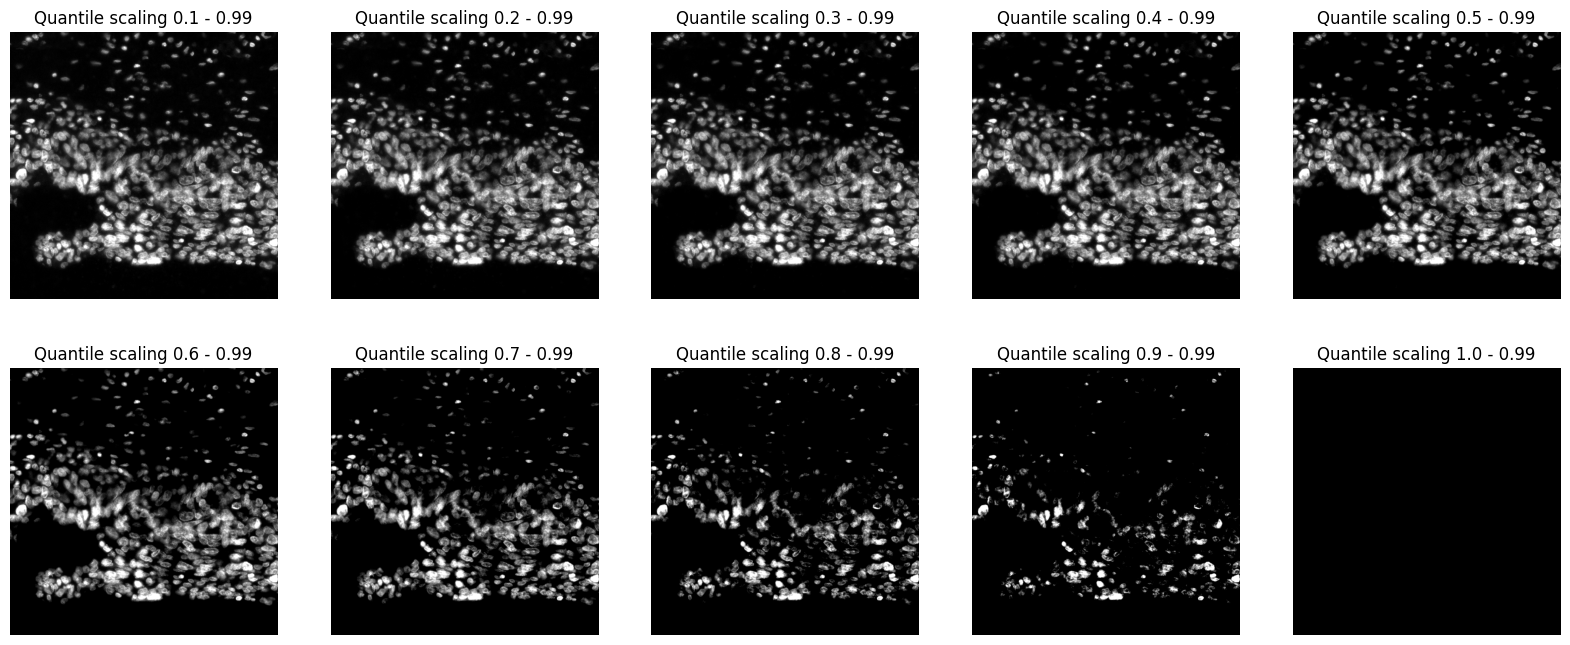

In [51]:
# plot a figure with 10 subplots, each subplot showing a different quantile scaling
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(scaling(im[9, :, :], min_max_quantiles=[0.1 + i*0.1, 0.99]), cmap='gray')
    ax.set_title(f"Quantile scaling {round(0.1 + i*0.1,2)} - {0.99}")
    ax.axis('off')

## Now in DataArray

In [58]:
def scaling(data_array, min_max_quantiles=[0.5, 0.995]):
    q_min = data_array.quantile(min_max_quantiles[0], dim=None)
    q_max = data_array.quantile(min_max_quantiles[1], dim=None)
    clipped_channel = data_array.clip(min=q_min, max=q_max)
    rescaled_channel = (clipped_channel - q_min) / (q_max - q_min) * 255
    rescaled_channel_8bit = rescaled_channel.astype(np.uint8)
    return rescaled_channel_8bit

In [73]:
def calculate_quantile(sdata, key: str, channels: list, quantile_value: float = 0.9, return_ArrayData: bool = False, min_max_scaling_quantiles=[0.5, 0.995]):

    image = sdata.images[key]['scale0'].image
    assert type(image) == xarray.core.dataarray.DataArray, 'Image is not a xarray DataArray'
    selected_channels_image = image.sel(c=channels)

    # def scaling(data_array, min_max_quantiles=[0.5, 0.995]):
    #     q_min = data_array.quantile(min_max_quantiles[0], dim=('x', 'y'), skipna=True)
    #     q_max = data_array.quantile(min_max_quantiles[1], dim=('x', 'y'), skipna=True)
    #     clipped_channel = data_array.clip(min=q_min, max=q_max)
    #     rescaled_channel = (clipped_channel - q_min) / (q_max - q_min) * 255
    #     rescaled_channel_8bit = rescaled_channel.astype(np.uint8)
    #     return rescaled_channel_8bit

    def scaling(data_array, min_max_quantiles=[0.5, 0.995]):
        
        data_array = data_array.chunk(dict(x=-1, y=-1))

        q_min = data_array.quantile(min_max_quantiles[0], dim=('x', 'y'), skipna=True)
        q_max = data_array.quantile(min_max_quantiles[1], dim=('x', 'y'), skipna=True)
        clipped_channel = data_array.clip(min=q_min, max=q_max)
        rescaled_channel = (clipped_channel - q_min) / (q_max - q_min) * 255.0
        rescaled_channel_8bit = rescaled_channel.astype(np.uint8)
        return rescaled_channel_8bit


    max_scaled_channels = xarray.concat([scaling(selected_channels_image.sel(c=c), min_max_scaling_quantiles) for c in channels], dim='c')
    quantile_projection = max_scaled_channels.quantile(quantile_value, dim='c', keep_attrs=True, interpolation='linear')
    quantile_projection_expanded = quantile_projection.expand_dims(dim='c', axis=0)

    if return_ArrayData:
        return quantile_projection_expanded
    else:
        sdata.images[f'{key}_q{int(quantile_value*100)}_projection'] = spatialdata.models.Image2DModel.parse(data=quantile_projection_expanded)
        return sdata

### Example xarray.ArrayData

In [142]:
array = sdata.images['991_subset']['scale0'].image.sel(c=['DAPI_1'])

In [143]:
array

<xarray.DataArray 'image' (c: 1, y: 8000, x: 8000)> Size: 128MB
dask.array<getitem, shape=(1, 8000, 8000), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U8 32B 'DAPI_1'
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
Attributes:
    transform:  {'pixels': Identity }

In [171]:
data_array = array.chunk(dict(x=-1, y=-1))

In [172]:
data_array

<xarray.DataArray 'image' (c: 1, y: 8000, x: 8000)> Size: 128MB
dask.array<rechunk-merge, shape=(1, 8000, 8000), dtype=uint16, chunksize=(1, 8000, 8000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U8 32B 'DAPI_1'
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
Attributes:
    transform:  {'pixels': Identity }

In [173]:
q_min = data_array.quantile(0.50, dim=('x', 'y')).values[0]
q_max = data_array.quantile(0.95, dim=('x', 'y')).values[0]

In [174]:
image = sdata.images['991_subset']['scale0'].image

In [175]:
image

<xarray.DataArray 'image' (c: 15, y: 8000, x: 8000)> Size: 2GB
dask.array<rechunk-merge, shape=(15, 8000, 8000), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U8 480B '750_bg' '647_bg' '555_bg' ... 'CD68' 'Ki67' 'DAPI_2'
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
Attributes:
    transform:  {'pixels': Identity }

In [176]:
selected_channels_image = image.sel(c=['DAPI_1', 'DAPI_2'])

In [177]:
selected_channels_image

<xarray.DataArray 'image' (c: 2, y: 8000, x: 8000)> Size: 256MB
dask.array<getitem, shape=(2, 8000, 8000), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U8 64B 'DAPI_1' 'DAPI_2'
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
Attributes:
    transform:  {'pixels': Identity }

In [178]:
data_arrays = [selected_channels_image.sel(c=c) for c in ['DAPI_1', 'DAPI_2']]

In [184]:
data_arrays[1]

<xarray.DataArray 'image' (y: 8000, x: 8000)> Size: 128MB
dask.array<getitem, shape=(8000, 8000), dtype=uint16, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    c        <U8 32B 'DAPI_2'
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
Attributes:
    transform:  {'pixels': Identity }

In [188]:
def scaling(data_array, min_max_quantiles=[0.5, 0.995]):
    data_array = data_array.chunk(dict(x=-1, y=-1))
    q_min = data_array.quantile(min_max_quantiles[0], dim=('x', 'y')).values
    q_max = data_array.quantile(min_max_quantiles[1], dim=('x', 'y')).values
    clipped_channel = data_array.clip(min=q_min, max=q_max)
    rescaled_channel = (clipped_channel - q_min) / (q_max - q_min) * 255.0
    rescaled_channel_8bit = rescaled_channel.astype(np.uint8)
    return rescaled_channel_8bit

In [189]:
scaled_data_arrays = [scaling(data_array, [0.5, 0.99]) for data_array in data_arrays]

In [195]:
scaled_data_arrays[0].values

array([[ 0,  0,  0, ...,  3,  9,  6],
       [ 0,  0,  0, ...,  7, 10,  6],
       [ 0,  0,  0, ...,  4, 10, 11],
       ...,
       [ 1,  3,  0, ..., 72, 50, 50],
       [ 7,  8,  3, ..., 60, 43, 44],
       [ 1,  0,  4, ..., 57, 47, 43]], dtype=uint8)

In [194]:
scaled_data_arrays[1].values

array([[ 0,  0,  0, ..., 18, 17, 25],
       [ 0,  0,  0, ..., 14, 22, 19],
       [ 0,  0,  0, ..., 16, 18, 24],
       ...,
       [ 0,  0,  0, ..., 68, 46, 60],
       [ 3,  0,  0, ..., 55, 59, 30],
       [ 0,  1,  0, ..., 53, 56, 37]], dtype=uint8)

In [196]:
concat_data_array = xarray.concat(scaled_data_arrays, dim='c')

In [200]:
concat_data_array

<xarray.DataArray 'image' (c: 2, y: 8000, x: 8000)> Size: 128MB
dask.array<concatenate, shape=(2, 8000, 8000), dtype=uint8, chunksize=(1, 8000, 8000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U8 64B 'DAPI_1' 'DAPI_2'
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03

In [206]:
# Assuming concat_data_array is your DataArray with dimension 'c' having multiple chunks
concat_data_array = concat_data_array.chunk({'c': -1})  # Rechunk along dimension 'c' to a single chunk
# quantile_projection = concat_data_array.quantile(0.5, dim='c')  # Now compute quantile

In [207]:
concat_data_array

<xarray.DataArray 'image' (c: 2, y: 8000, x: 8000)> Size: 128MB
dask.array<rechunk-merge, shape=(2, 8000, 8000), dtype=uint8, chunksize=(2, 8000, 8000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U8 64B 'DAPI_1' 'DAPI_2'
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03

In [208]:
quantile_projection = concat_data_array.quantile(0.5, dim='c')

## It provides a calculation object of sorts

In [219]:
def calculate_quantile(sdata, key: str, channels: list, quantile_value: float = 0.9, return_ArrayData: bool = False, min_max_scaling_quantiles=[0.5, 0.995]):

    image = sdata.images[key]['scale0'].image
    assert type(image) == xarray.core.dataarray.DataArray, 'Image is not a xarray DataArray'
    selected_channels_image = image.sel(c=channels)

    def scaling(data_array, min_max_quantiles=[0.5, 0.995]):
        data_array = data_array.chunk(dict(x=-1, y=-1))
        q_min = data_array.quantile(min_max_quantiles[0], dim=('x', 'y')).values
        q_max = data_array.quantile(min_max_quantiles[1], dim=('x', 'y')).values
        clipped_channel = data_array.clip(min=q_min, max=q_max)
        rescaled_channel = (clipped_channel - q_min) / (q_max - q_min) * 255.0
        rescaled_channel_8bit = rescaled_channel.astype(np.uint8)
        return rescaled_channel_8bit

    data_arrays = [selected_channels_image.sel(c=c) for c in channels]
    scaled_data_arrays = [scaling(data_array, min_max_scaling_quantiles) for data_array in data_arrays]
    concat_data_array = xarray.concat(scaled_data_arrays, dim='c').chunk({'c': -1})

    quantile_projection = concat_data_array.quantile(quantile_value, dim='c')
    quantile_projection_expanded = quantile_projection.expand_dims(dim='c', axis=0)

    if return_ArrayData:
        return quantile_projection_expanded
    else:
        sdata.images[f'{key}_q{int(quantile_value*100)}_projection'] = spatialdata.models.Image2DModel.parse(data=quantile_projection_expanded)
        return sdata
    
def quantiles_nuclear_membrane(sdata, key:str, 
                            nuclear_channels:list=None, 
                            nuclear_quantile:float=0.9,
                            nuclear_min_max_quantiles:list=[0.5, 0.995],
                            membrane_channels:list=None,
                            membrane_quantile:float=0.9,
                            membrane_min_max_quantiles:list=[0.5, 0.995]):

    nuclear_ArrayData = calculate_quantile(sdata, key, nuclear_channels, nuclear_quantile, return_ArrayData=True, min_max_scaling_quantiles=nuclear_min_max_quantiles)
    membrane_ArrayData = calculate_quantile(sdata, key, membrane_channels, membrane_quantile, return_ArrayData=True, min_max_scaling_quantiles=membrane_min_max_quantiles)

    concatenated_array = spatialdata.models.Image2DModel.parse(xarray.concat([nuclear_ArrayData, membrane_ArrayData], dim='c'), transformations={"pixels":Identity()})
    
    name = f'{key}_n{int(nuclear_quantile*100)}_m{int(membrane_quantile*100)}_mmm{str(membrane_min_max_quantiles[0]).replace(".","")}_proj'

    sdata.images[name] = concatenated_array
    sdata.images[name] = sdata.images[name].assign_coords(c=['Nuclei', 'Membranes'])
    return sdata

In [220]:
sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m85_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        991_subset_n90_m85_proj (Images)
    ▸ 'pixels', with elements:
        991_subset (Images), sopa_patches (Shapes)

In [215]:
sdata = quantiles_nuclear_membrane(sdata, '991_subset', 
                                nuclear_channels=["DAPI_1", "DAPI_2"],
                                nuclear_quantile=0.9,
                                nuclear_min_max_quantiles=[0.5, 0.995],
                                membrane_channels=['Vimentin', 'CD3e', 'panCK', 'CD8', 'COL1A1', 'CD20', 'CD68'],
                                membrane_quantile=0.85,
                                membrane_min_max_quantiles=[0.5, 0.995])

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [216]:
sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m85_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        991_subset_n90_m85_proj (Images)
    ▸ 'pixels', with elements:
        991_subset (Images), sopa_patches (Shapes)

In [221]:
quantiles = [0.2, 0.3, 0.4, 0.5, 0.6]

for quantile in quantiles:
    quantile_list = [quantile, 0.99]
    sdata = quantiles_nuclear_membrane(sdata, '991_subset',
                                    nuclear_channels=["DAPI_1", "DAPI_2"],
                                    nuclear_quantile=0.9,
                                    nuclear_min_max_quantiles=quantile_list,
                                    membrane_channels=['Vimentin', 'CD3e', 'panCK', 'CD8', 'COL1A1', 'CD20', 'CD68'],
                                    membrane_quantile=0.85,
                                    membrane_min_max_quantiles=quantile_list)

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_mmm02_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_mmm03_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_mmm04_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m85_mmm05_proj` already exists. Overwriting it in-memory.
  self._check_k

In [222]:
napari_spatialdata.Interactive(sdata)

2024-07-18 14:36:54.534 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:36:54.535 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:11.056 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:11.057 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:38.921 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:38.923 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:45.532 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:45.534 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:55.645 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 14:37:55.646 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updati

In [224]:
#save sdata
sdata.write("../zarrs/20240718_membrane_nuclear_quantiles.zarr")

INFO     The Zarr backing store has been changed from None the new file path:                                      
         ../zarrs/20240718_membrane_nuclear_quantiles.zarr                                                         


In [227]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240718_membrane_nuclear_quantiles.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     ├── '991_subset_n90_m85_mmm02_proj': DataArray[cyx] (2, 8000, 8000)
│     ├── '991_subset_n90_m85_mmm03_proj': DataArray[cyx] (2, 8000, 8000)
│     ├── '991_subset_n90_m85_mmm04_proj': DataArray[cyx] (2, 8000, 8000)
│     ├── '991_subset_n90_m85_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
│     ├── '991_subset_n90_m85_mmm06_proj': DataArray[cyx] (2, 8000, 8000)
│     └── '991_subset_n90_m85_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        991_subset_n90_m85_mmm02_proj (Images), 991_subset_n90_m85_mmm03_proj (Images), 991_subset_n90_m85_mmm04_proj (Images), 991_subset_n90_m85_mmm05_proj (Ima

In [228]:
def plot_dynamic_subplots(sdata, crop=None, save_png=False):

    shape_titles = list(sdata.images.keys())
    shape_titles.remove("991_subset")

    num_plots = len(shape_titles)
    num_cols = round(math.sqrt(num_plots))
    num_rows = num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    fig.patch.set_facecolor('black')
    
    axes = axes.flatten() if num_plots > 1 else [axes]

    if crop is not None:
        cropped_sdata = sdata.query.bounding_box(
            axes=["x", "y"],
            min_coordinate=[crop[0], crop[1]],
            max_coordinate=[crop[2], crop[3]],
            target_coordinate_system='pixels')

    for ax, title in zip(axes, shape_titles):
        ax.set_facecolor('black')
        ax.title.set_color('white')

        if crop is not None:
            try:
                cropped_sdata.pl.render_images(element=title, alpha=0.85, channel=["Membranes"], palette=['green']).pl.show(ax=ax, title=title)
            except:
                print(f"Could not render {title} in the specified crop area.")
        else:
            try:
                sdata.pl.render_images(element=title, alpha=0.85, channel=["Membranes"], palette=['green']).pl.show(ax=ax, title=title)
            except:
                print(f"Could not render {title} in the specified")

    # Hide any unused subplots
    for ax in axes[len(shape_titles):]:
        ax.set_visible(False)

    plt.tight_layout()
    if save_png:
        plt.savefig(save_png, dpi=250, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()

Could not render 991_subset_n90_m85_proj in the specified crop area.
Could not render 991_subset_n90_m85_mmm02_proj in the specified crop area.
Could not render 991_subset_n90_m85_mmm03_proj in the specified crop area.
Could not render 991_subset_n90_m85_mmm04_proj in the specified crop area.
Could not render 991_subset_n90_m85_mmm05_proj in the specified crop area.
Could not render 991_subset_n90_m85_mmm06_proj in the specified crop area.


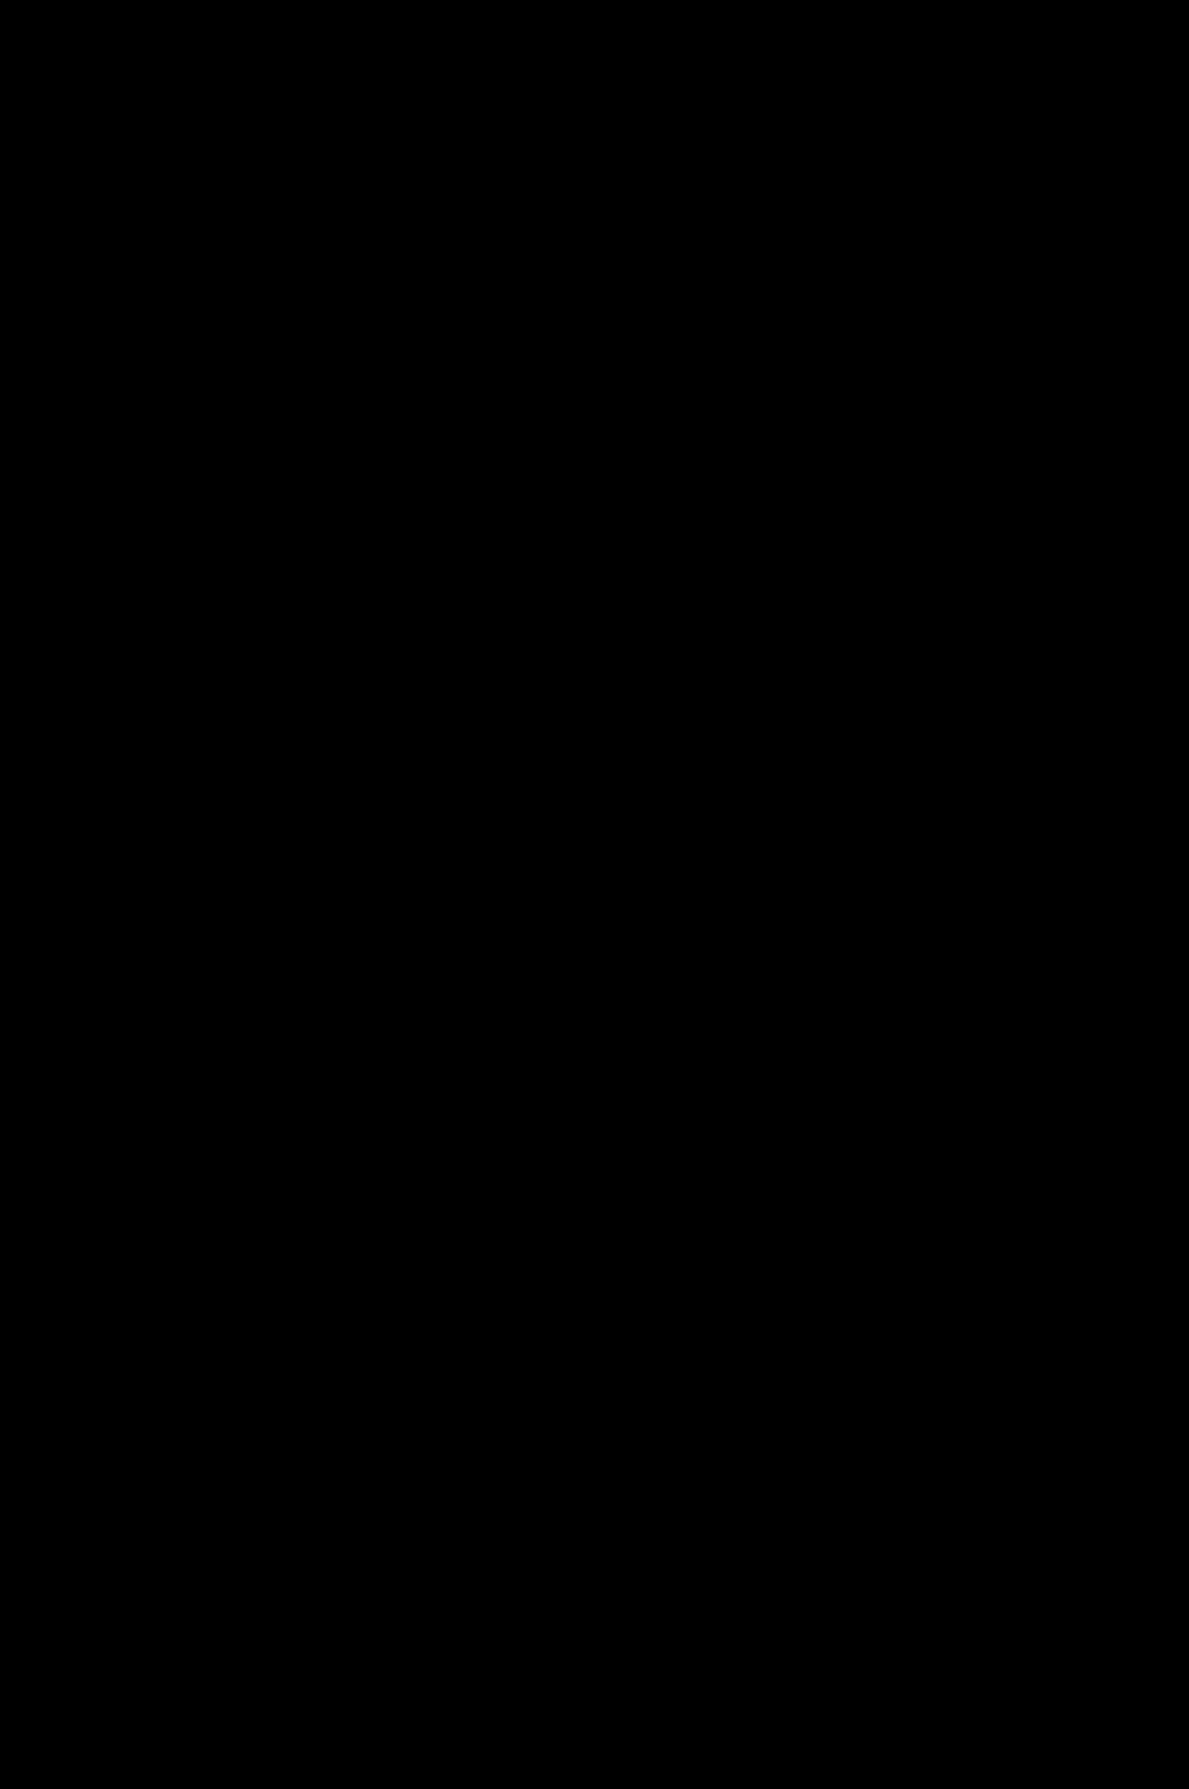

In [229]:
plot_dynamic_subplots(sdata, crop=[1000, 1000, 2000, 2000])

In [238]:

crop = [1000, 1000, 2000, 2000]
cropped_sdata = sdata.query.bounding_box(
            axes=["x", "y"],
            min_coordinate=[crop[0], crop[1]],
            max_coordinate=[crop[2], crop[3]],
            target_coordinate_system='global')

In [239]:
cropped_sdata

SpatialData object
└── Images
      ├── '991_subset_n90_m85_mmm02_proj': DataArray[cyx] (2, 1000, 1000)
      ├── '991_subset_n90_m85_mmm03_proj': DataArray[cyx] (2, 1000, 1000)
      ├── '991_subset_n90_m85_mmm04_proj': DataArray[cyx] (2, 1000, 1000)
      ├── '991_subset_n90_m85_mmm05_proj': DataArray[cyx] (2, 1000, 1000)
      ├── '991_subset_n90_m85_mmm06_proj': DataArray[cyx] (2, 1000, 1000)
      └── '991_subset_n90_m85_proj': DataArray[cyx] (2, 1000, 1000)
with coordinate systems:
    ▸ 'global', with elements:
        991_subset_n90_m85_mmm02_proj (Images), 991_subset_n90_m85_mmm03_proj (Images), 991_subset_n90_m85_mmm04_proj (Images), 991_subset_n90_m85_mmm05_proj (Images), 991_subset_n90_m85_mmm06_proj (Images), 991_subset_n90_m85_proj (Images)

In [243]:
def plot_dynamic_subplots(sdata, crop=None, save_png=False, coordenate_system="pixels"):

    if crop is not None:
        cropped_sdata = sdata.query.bounding_box(
            axes=["x", "y"],
            min_coordinate=[crop[0], crop[1]],
            max_coordinate=[crop[2], crop[3]],
            target_coordinate_system=coordenate_system)
    
    if crop is not None:
        shape_titles = list(cropped_sdata.images.keys())
    else:
        shape_titles = list(sdata.images.keys())

    num_plots = len(shape_titles)
    num_cols = round(math.sqrt(num_plots))
    num_rows = num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    fig.patch.set_facecolor('black')
    
    axes = axes.flatten() if num_plots > 1 else [axes]

    for ax, title in zip(axes, shape_titles):
        ax.set_facecolor('black')
        ax.title.set_color('white')

        if crop is not None:
            try:
                cropped_sdata.pl.render_images(element=title, alpha=1, channel=["Membranes"], palette=['green'], ).pl.show(ax=ax, title=title)
            except:
                print(f"Could not render {title} in the specified crop area.")
        else:
            try:
                sdata.pl.render_images(element=title, alpha=0.85, channel=["Membranes"], palette=['green']).pl.show(ax=ax, title=title)
            except:
                print(f"Could not render {title} in the specified")

    # Hide any unused subplots
    for ax in axes[len(shape_titles):]:
        ax.set_visible(False)

    plt.tight_layout()
    if save_png:
        plt.savefig(save_png, dpi=250, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()

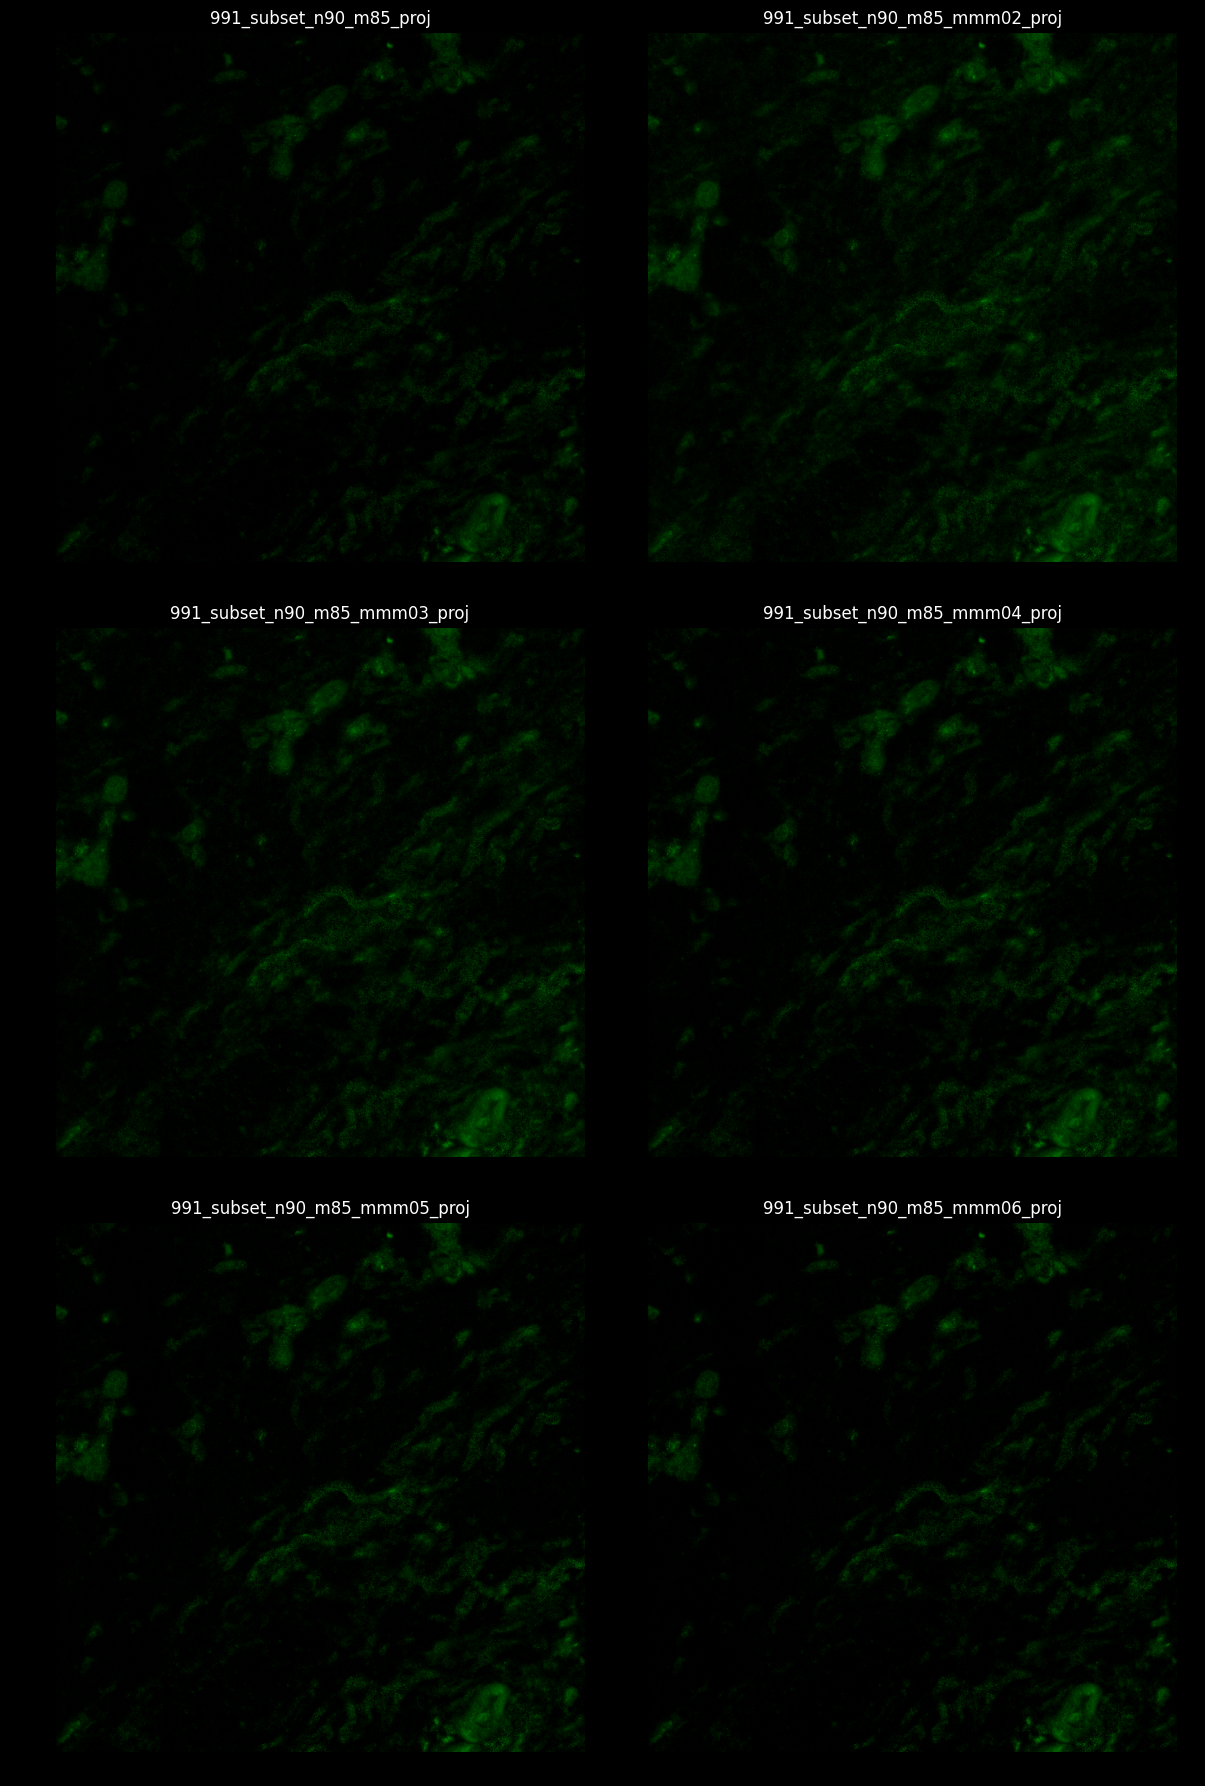

In [244]:
plot_dynamic_subplots(sdata, crop=[1000, 1000, 2000, 2000], coordenate_system="global")

Could not render 991_subset in the specified crop area.


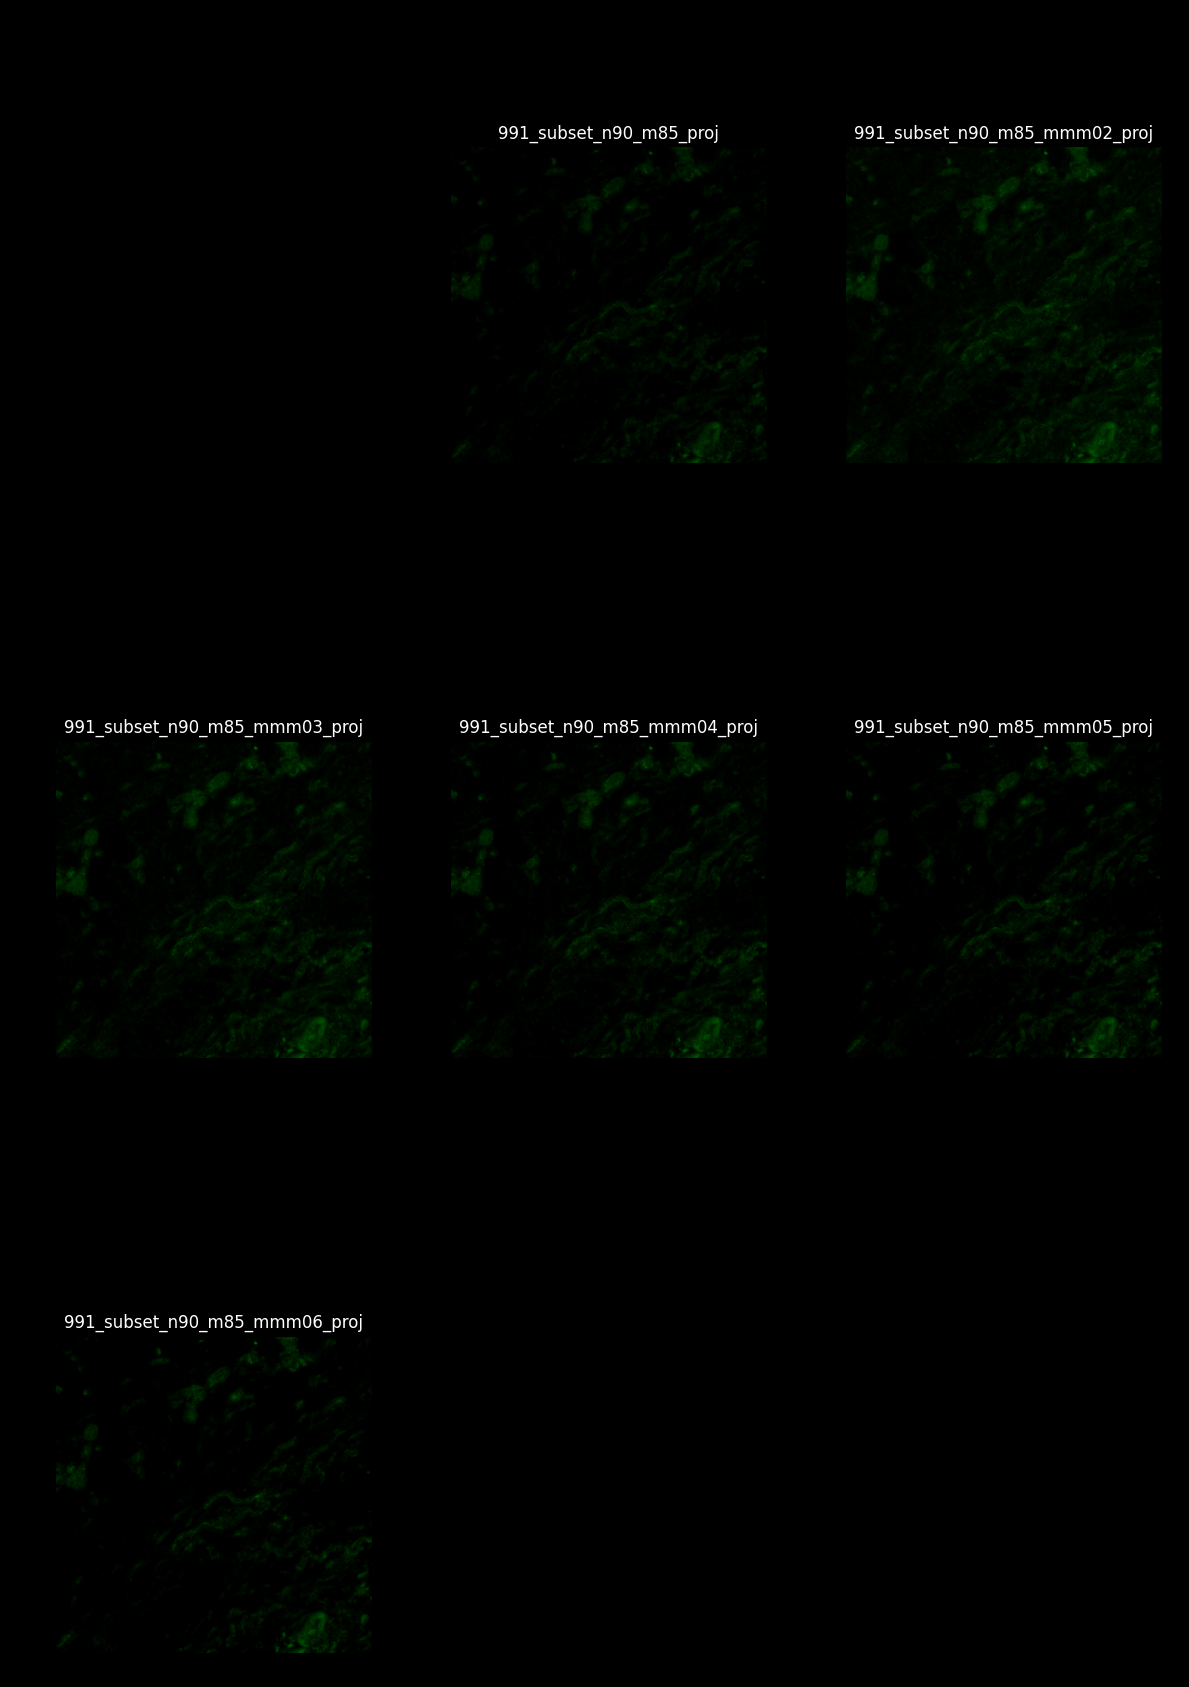

In [ ]:
plot_dynamic_subplots(sdata, crop=[1000, 1000, 2000, 2000], coordenate_system="global")

# try to create images on the same coordenates